In [1]:
import numpy as np
import pandas as pd
import pickle

from isttc.scripts.cfg_global import project_folder_path

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
dataset_folder = project_folder_path + 'synthetic_dataset\\'
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau_comp_time\\full_signal\\'

fig_folder = results_folder
save_fig = False

In [4]:
def get_compute_time_df(acf_dict_, signal_len_, method_, alphas_, fr_values_, taus_ms_, bin_size_=50):
    data = []
    for unit_id, unit_data in acf_dict_.items():
        data.append({
            'unit_id': unit_id,
            'elapsed_time_acf_sec': unit_data['elapsed_time_acf'],
            'elapsed_time_tau_fit_sec': unit_data['elapsed_time_tau_fit']
            
        })
    compute_time_df = pd.DataFrame(data)
    compute_time_df['method'] = method_
    compute_time_df['bin_size'] = bin_size_
    compute_time_df['duration_s'] = signal_len_
    compute_time_df['fr'] = fr_values_
    compute_time_df['alpha'] = alphas_
    compute_time_df['tau_ms_true'] = taus_ms_

    rows_with_nans_df = compute_time_df[compute_time_df.isna().any(axis=1)]
    n_rows_with_nan = len(rows_with_nans_df)
    print(f'N rows with NaNs {n_rows_with_nan}')
    
    return compute_time_df

def get_trials_plot_df(trial_dict_, n_trials_, method_, alphas_, fr_values_, taus_ms_, n_iteration_=None, bin_size_=50):
    records = []
    for unit_id, data in trial_dict_.items():
        elapsed_time_acf = data['elapsed_time_acf']
        elapsed_time_tau_fit = data['elapsed_time_tau_fit']

        if n_iteration_ is not None:
            # only one trial per unit
            idx = n_iteration_[unit_id]
            taus_to_iter = [(elapsed_time_acf[idx], elapsed_time_tau_fit[idx])]
        else:
            # all trials for this unit
            taus_to_iter = zip(elapsed_time_acf, elapsed_time_tau_fit)

        for time_acf, time_fit in taus_to_iter:
            records.append({
                'unit_id': unit_id,
                'elapsed_time_acf_sec': time_acf,
                'elapsed_time_tau_fit_sec': time_fit,
                'method': method_,
            })

    compute_time_df = pd.DataFrame.from_records(records)
    compute_time_df['n_trials'] = n_trials_
    compute_time_df['bin_size'] = bin_size_
    compute_time_df['fr'] = fr_values_
    compute_time_df['alpha'] = alphas_
    compute_time_df['tau_ms_true'] = taus_ms_

    nan_count = compute_time_df.isna().any(axis=1).sum()
    if nan_count > 0:
        print(f'N rows with NaNs {nan_count}')

    return compute_time_df

In [5]:
with open(dataset_folder + 'spike_trains.pkl', 'rb') as f:
    data = pickle.load(f)

spike_trains = data['spike_trains']
alphas = data['alphas']
fr_values = data['fr_values']
taus_ms = data['tau_ms']
duration_ms = data['duration_ms']

print(f'n spike trains {len(spike_trains)}, len {spike_trains[0][-1]/1000}, duration_ms {duration_ms}')

n spike trains 100000, len 598.8243581617338, duration_ms [600000 600000 600000 ... 600000 600000 600000]


In [6]:
with open(results_folder + 'acf_full_50ms_20lags_dict.pkl', "rb") as f:
    acf_full_dict = pickle.load(f)

with open(results_folder + 'acf_isttc_full_50ms_20lags_dict.pkl', "rb") as f:
    isttc_full_dict = pickle.load(f)

acf_tau_full_df = get_compute_time_df(acf_full_dict, 600, 'acf_full', alphas, fr_values, taus_ms, bin_size_=50)
isttc_tau_full_df = get_compute_time_df(isttc_full_dict, 600, 'isttc_full', alphas, fr_values, taus_ms, bin_size_=50)

tau_all_long_df = pd.concat([acf_tau_full_df, isttc_tau_full_df])
tau_all_long_df.reset_index(inplace=True, drop=True)
tau_all_long_df['total_time_sec'] = tau_all_long_df['elapsed_time_tau_fit_sec'] + tau_all_long_df['elapsed_time_acf_sec']
tau_all_long_df['elapsed_time_tau_fit_sec_log10'] = np.log10(tau_all_long_df['elapsed_time_tau_fit_sec'])
tau_all_long_df['elapsed_time_acf_sec_log10'] = np.log10(tau_all_long_df['elapsed_time_acf_sec'])
tau_all_long_df['total_time_sec_log10'] = np.log10(tau_all_long_df['total_time_sec'])

# tau_all_long_df.to_csv(results_folder + 'compute_time_full_long_df_all_units.csv')
# tau_all_long_df.to_pickle(results_folder + 'compute_time_full_long_df_all_units.pkl')

tau_all_long_df

N rows with NaNs 0
N rows with NaNs 0


,unit_id,elapsed_time_acf_sec,elapsed_time_tau_fit_sec,method,bin_size,duration_s,fr,alpha,tau_ms_true,total_time_sec,elapsed_time_tau_fit_sec_log10,elapsed_time_acf_sec_log10,total_time_sec_log10
0,0,0.003302,0.006644,acf_full,50,600,7.741821,0.851099,150.923515,0.009946,-2.177544,-2.481249,-2.002343
1,1,0.002150,0.007798,acf_full,50,600,4.394396,0.858098,147.947233,0.009949,-2.108006,-2.667481,-2.002238
2,2,0.001988,0.009277,acf_full,50,600,8.587393,0.528805,267.002290,0.011264,-2.032606,-2.701649,-1.948292
3,3,0.001862,0.008906,acf_full,50,600,6.976707,0.300692,194.403797,0.010769,-2.050303,-2.729974,-1.967845
4,4,0.001893,0.006139,acf_full,50,600,0.950832,0.691458,239.986489,0.008032,-2.211895,-2.722849,-2.095171
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,99995,0.140149,0.005196,isttc_full,50,600,2.672839,0.244627,125.243251,0.145345,-2.284364,-0.853409,-0.837600
199996,99996,0.313701,0.003456,isttc_full,50,600,5.754497,0.596987,94.481295,0.317157,-2.461401,-0.503484,-0.498725
199997,99997,0.305832,0.005838,isttc_full,50,600,5.604441,0.258915,174.189672,0.311670,-2.233773,-0.514517,-0.506305
199998,99998,0.068599,0.005801,isttc_full,50,600,1.219057,0.187620,76.565797,0.074400,-2.236505,-1.163680,-1.128425


In [15]:
with open(results_folder + 'var_len\\acf_full_50ms_20lags_dict_60ms.pkl', "rb") as f:
    acf_full_dict_60 = pickle.load(f)

with open(results_folder + 'var_len\\acf_full_50ms_20lags_dict_150ms.pkl', "rb") as f:
    acf_full_dict_150 = pickle.load(f)

with open(results_folder + 'var_len\\acf_full_50ms_20lags_dict_300ms.pkl', "rb") as f:
    acf_full_dict_300 = pickle.load(f)

with open(results_folder + 'var_len\\acf_full_50ms_20lags_dict_450ms.pkl', "rb") as f:
    acf_full_dict_450 = pickle.load(f)

with open(results_folder + 'var_len\\acf_isttc_full_50ms_20lags_dict_60ms.pkl', "rb") as f:
    isttc_full_dict_60 = pickle.load(f)

with open(results_folder + 'var_len\\acf_isttc_full_50ms_20lags_dict_150ms.pkl', "rb") as f:
    isttc_full_dict_150 = pickle.load(f)

with open(results_folder + 'var_len\\acf_isttc_full_50ms_20lags_dict_300ms.pkl', "rb") as f:
    isttc_full_dict_300 = pickle.load(f)

with open(results_folder + 'var_len\\acf_isttc_full_50ms_20lags_dict_450ms.pkl', "rb") as f:
    isttc_full_dict_450 = pickle.load(f)


acf_tau_full_df_60 = get_compute_time_df(acf_full_dict_60, 60, 'acf_full', alphas[:1000], fr_values[:1000], taus_ms[:1000], bin_size_=50)
acf_tau_full_df_150 = get_compute_time_df(acf_full_dict_150, 150, 'acf_full', alphas[:1000], fr_values[:1000], taus_ms[:1000], bin_size_=50)
acf_tau_full_df_300 = get_compute_time_df(acf_full_dict_300, 300, 'acf_full', alphas[:1000], fr_values[:1000], taus_ms[:1000], bin_size_=50)
acf_tau_full_df_450 = get_compute_time_df(acf_full_dict_450, 450, 'acf_full', alphas[:1000], fr_values[:1000], taus_ms[:1000], bin_size_=50)

isttc_tau_full_df_60 = get_compute_time_df(isttc_full_dict_60, 60, 'isttc_full', alphas[:1000], fr_values[:1000], taus_ms[:1000], bin_size_=50)
isttc_tau_full_df_150 = get_compute_time_df(isttc_full_dict_150, 150, 'isttc_full', alphas[:1000], fr_values[:1000], taus_ms[:1000], bin_size_=50)
isttc_tau_full_df_300 = get_compute_time_df(isttc_full_dict_300, 300, 'isttc_full', alphas[:1000], fr_values[:1000], taus_ms[:1000], bin_size_=50)
isttc_tau_full_df_450 = get_compute_time_df(isttc_full_dict_450, 450, 'isttc_full', alphas[:1000], fr_values[:1000], taus_ms[:1000], bin_size_=50)

tau_all_long_len_df = pd.concat([acf_tau_full_df_60, acf_tau_full_df_150, acf_tau_full_df_300, acf_tau_full_df_450, 
                            isttc_tau_full_df_60, isttc_tau_full_df_150, isttc_tau_full_df_300, isttc_tau_full_df_450])
tau_all_long_len_df.reset_index(inplace=True, drop=True)
tau_all_long_len_df['total_time_sec'] = tau_all_long_df['elapsed_time_tau_fit_sec'] + tau_all_long_len_df['elapsed_time_acf_sec']
tau_all_long_len_df['elapsed_time_tau_fit_sec_log10'] = np.log10(tau_all_long_len_df['elapsed_time_tau_fit_sec'])
tau_all_long_len_df['elapsed_time_acf_sec_log10'] = np.log10(tau_all_long_len_df['elapsed_time_acf_sec'])
tau_all_long_len_df['total_time_sec_log10'] = np.log10(tau_all_long_len_df['total_time_sec'])

tau_all_long_len_df = pd.concat([tau_all_long_len_df, tau_all_long_df.query('unit_id < 1000').copy()])
tau_all_long_len_df.reset_index(inplace=True, drop=True)

tau_all_long_len_df.to_csv(results_folder + 'var_len\\compute_time_full_long_df_1000_units.csv')
tau_all_long_len_df.to_pickle(results_folder + 'var_len\\compute_time_full_long_df_1000_units.pkl')

tau_all_long_len_df

N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 0
N rows with NaNs 0


,unit_id,elapsed_time_acf_sec,elapsed_time_tau_fit_sec,method,bin_size,duration_s,fr,alpha,tau_ms_true,total_time_sec,elapsed_time_tau_fit_sec_log10,elapsed_time_acf_sec_log10,total_time_sec_log10
0,0,0.003414,0.004755,acf_full,50,60,7.741821,0.851099,150.923515,0.010058,-2.322859,-2.466736,-1.997471
1,1,0.000213,0.004850,acf_full,50,60,4.394396,0.858098,147.947233,0.008011,-2.314267,-3.671825,-2.096308
2,2,0.000172,0.004864,acf_full,50,60,8.587393,0.528805,267.002290,0.009449,-2.312989,-3.763966,-2.024619
3,3,0.000162,0.007947,acf_full,50,60,6.976707,0.300692,194.403797,0.009069,-2.099775,-3.789414,-2.042455
4,4,0.000161,0.007219,acf_full,50,60,0.950832,0.691458,239.986489,0.006300,-2.141505,-3.793984,-2.200673
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,995,0.246385,0.006480,isttc_full,50,600,4.385516,0.445582,268.936961,0.252864,-2.188458,-0.608386,-0.597113
9996,996,0.362632,0.004205,isttc_full,50,600,6.393746,0.711274,203.491734,0.366837,-2.376244,-0.440534,-0.435527
9997,997,0.001708,0.009683,isttc_full,50,600,0.033065,0.695408,210.248651,0.011391,-2.013981,-2.767588,-1.943442
9998,998,0.583728,0.005965,isttc_full,50,600,9.933751,0.411936,261.093282,0.589693,-2.224360,-0.233790,-0.229374


### Plots

In [16]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2' 
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_avg =  '#a49fce' 
color_sttc_trail_concat = '#955da2' 

colors = [color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_concat]

colors_full = [color_acf_full, color_isttc_full]

       method  elapsed_time_acf_sec  elapsed_time_tau_fit_sec  total_time_sec  \
0    acf_full            172.964413               1238.461011     1411.425424   
1  isttc_full          27696.602776                865.135300    28561.738077   

   total_time_min  total_time_h  
0       23.523757      0.392063  
1      476.028968      7.933816  


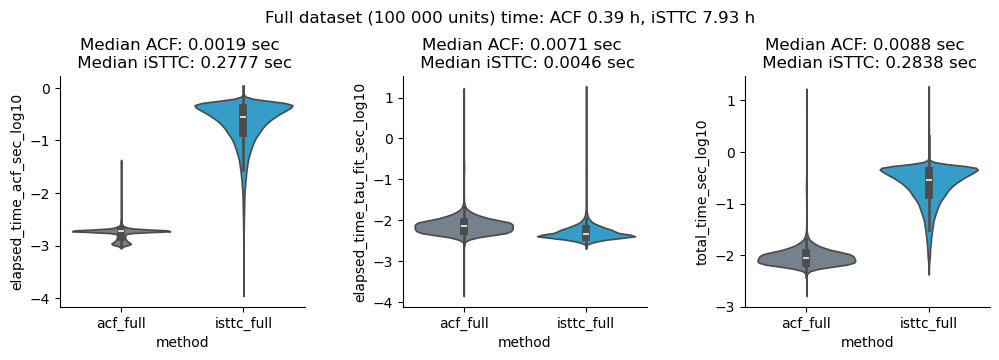

In [18]:
total_time_df = tau_all_long_df.groupby(by='method', as_index=False)[['elapsed_time_acf_sec', 'elapsed_time_tau_fit_sec', 'total_time_sec']].sum()
total_time_df['total_time_min'] = total_time_df['total_time_sec'] / 60
total_time_df['total_time_h'] = total_time_df['total_time_min'] / 60

print(total_time_df)


fig, axes = plt.subplots(1,3, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.violinplot(x='method', y='elapsed_time_acf_sec_log10', hue='method',
               palette=colors_full, data=tau_all_long_df , cut=0, ax=axes[0])
axes[0].set_title(f"Median ACF: {tau_all_long_df.groupby('method')['elapsed_time_acf_sec'].median()['acf_full']:.4f} sec \n Median iSTTC: {tau_all_long_df.groupby('method')['elapsed_time_acf_sec'].median()['isttc_full']:.4f} sec")

sns.violinplot(x='method', y='elapsed_time_tau_fit_sec_log10', hue='method',
               palette=colors_full, data=tau_all_long_df , cut=0, ax=axes[1])
axes[1].set_title(f"Median ACF: {tau_all_long_df.groupby('method')['elapsed_time_tau_fit_sec'].median()['acf_full']:.4f} sec \n Median iSTTC: {tau_all_long_df.groupby('method')['elapsed_time_tau_fit_sec'].median()['isttc_full']:.4f} sec")

sns.violinplot(x='method', y='total_time_sec_log10', hue='method',
               palette=colors_full, data=tau_all_long_df , cut=0, ax=axes[2])
axes[2].set_title(f"Median ACF: {tau_all_long_df.groupby('method')['total_time_sec'].median()['acf_full']:.4f} sec \n Median iSTTC: {tau_all_long_df.groupby('method')['total_time_sec'].median()['isttc_full']:.4f} sec")

for ax in axes.flat:
    sns.despine(ax=ax)

fig.suptitle(f'Full dataset (100 000 units) time: ACF {total_time_df.query('method == "acf_full"')['total_time_h'].values[0]:.2f} h, iSTTC {total_time_df.query('method == "isttc_full"')['total_time_h'].values[0]:.2f} h', y=1.1)
    
#axes[0].legend(frameon=False)

if save_fig:
    plt.savefig(fig_folder + 'full_signal_comp_time.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'full_signal_comp_time.svg' , bbox_inches='tight')